# Analyse d'un Modèle de Forêt Aléatoire pour l'Algorithmique de Trading

Dans ce notebook, nous allons explorer, construire et analyser un modèle de forêt aléatoire (Random Forest), un algorithme d'apprentissage automatique puissant et flexible, largement utilisé dans divers domaines, dont le trading algorithmique. Notre objectif est d'appliquer ce modèle pour prédire les mouvements du marché boursier, qui serviront de base pour notre stratégie de trading algorithmique.

## Contexte

Les marchés financiers sont des environnements complexes, dynamiques et incertains. L'immense quantité de données générées quotidiennement par ces marchés offre des opportunités uniques pour l'application d'algorithmes d'apprentissage automatique. Le trading algorithmique, en particulier, est un domaine où ces techniques peuvent être utilisées pour obtenir des avantages significatifs.

Un défi majeur dans le trading algorithmique est la prévision des mouvements du marché. Les modèles de forêt aléatoire, qui sont essentiellement des collections d'arbres de décision, ont été efficaces pour faire face à ce défi. En capitalisant sur le principe d'ensemble, les forêts aléatoires minimisent l'overfitting, offrent une grande flexibilité et maintiennent une précision élevée dans diverses conditions de marché.

## Objectifs

Dans ce notebook, nous allons:

1. Importer et préparer les données du marché pour l'entraînement et le test de notre modèle.
2. Construire et entraîner un modèle de forêt aléatoire en utilisant scikit-learn.
3. Évaluer la performance de notre modèle sur des données de test.
4. Utiliser notre modèle pour générer des signaux de trading pour notre algorithme de trading.

Bien que notre focus soit sur le trading algorithmique, les concepts et les techniques présentées ici sont généralement applicables à toute tâche de prédiction supervisée. Il est à noter que bien que nous cherchions à créer un modèle performant, la prédiction parfaite du mouvement du marché est une tâche extrêmement complexe, même pour les algorithmes les plus sophistiqués.

C'est parti !

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import warnings
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from itertools import product
from statsmodels.api import OLS, add_constant

warnings.simplefilter(action='ignore', category=FutureWarning)

In [99]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

# Annotation

Dans cette cellule, nous préparons notre ensemble de données pour l'entraînement du modèle RandomForest. 

Tout d'abord, nous chargeons les données à partir d'un fichier HDF5, qui est un format de fichier conçu pour stocker et organiser de grandes quantités de données. Nous remplaçons ensuite toutes les valeurs infinies par des valeurs NaN (Not a Number) pour éviter des problèmes lors de l'entraînement du modèle. Ensuite, nous supprimons toutes les lignes contenant au moins une valeur NaN.

Ensuite, nous sélectionnons les caractéristiques (features) que nous allons utiliser pour l'entraînement de notre modèle. Ces caractéristiques n'ont pas été choisies au hasard. Elles ont été sélectionnées grâce à de longues analyses et à l'utilisation d'outils tels que l'information mutuelle et le coefficient de Spearman.

L'information mutuelle entre deux variables aléatoires continues \(X\) et \(Y\) est définie par l'équation suivante :

$$
I(X; Y) = \int_Y \int_X p(x, y) \log\left(\frac{p(x, y)}{p(x)p(y)}\right) dx dy
$$

où \(p(x, y)\) est la densité de probabilité conjointe de \(X\) et \(Y\), et \(p(x)\) et \(p(y)\) sont les densités de probabilité marginales de \(X\) et \(Y\), respectivement.

Le coefficient de Spearman, quant à lui, est une mesure de la corrélation de rang entre deux variables. Il est défini par l'équation suivante :

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

où \(d_i\) est la différence entre les rangs de chaque observation, \(n\) est le nombre d'observations.

Enfin, nous séparons notre ensemble de données en deux : un ensemble de caractéristiques \(X\) (toutes les colonnes sauf 'target') et un ensemble de cibles \(y\) (la colonne 'target'). Nous définissons également les noms des indices de notre ensemble de données comme 'symbol' et 'date'.

In [100]:
with pd.HDFStore(r'..\data.h5') as hdf:
    data = hdf['final_set']

In [101]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(how='any', inplace=True)

In [102]:
new_columns = [c for c in data.columns if 'RSI' in c 
               or 'HT_' in c 
               or 'ADOSC' in c 
               or 'momentum' in c] + [c for c in data.columns 
                                      if 'frac_diff_km' in c 
                                      and 'lag_25' not in c] + [c for c in data.columns 
                                                                if 'frac_diff' in c 
                                                                and 'frac_diff_km' not in c] + ['VIX_SP500', 'target']

In [103]:
data = data[new_columns]

In [104]:
X = data.drop(['target'], axis=1)
y = data['target']

In [105]:
data.index.names = ['symbol', 'date']

Dans cette cellule, nous définissons notre modèle de forêt aléatoire (RandomForest) et la méthode de validation croisée que nous allons utiliser pour évaluer sa performance.

Tout d'abord, nous définissons une fonction `rank_correl` qui calcule le coefficient de corrélation de Spearman entre les valeurs réelles et prédites. Cette fonction sera utilisée comme métrique d'évaluation de notre modèle.

Ensuite, nous définissons les paramètres de notre validation croisée. Nous utilisons une approche de validation croisée temporelle, qui est particulièrement adaptée aux séries temporelles, car elle respecte l'ordre temporel des observations. Nous définissons la longueur de la période d'entraînement (`train_period_length`), la longueur de la période de test (`test_period_length`), et le nombre de divisions (`n_splits`). Le paramètre `lookahead` est utilisé pour décaler les périodes de test par rapport aux périodes d'entraînement, ce qui est utile pour éviter les fuites de données dans les séries temporelles.

Nous instancions ensuite notre modèle de forêt aléatoire avec des paramètres spécifiques. Ces paramètres ont été choisis en fonction de leur performance lors de tests précédents.

Enfin, nous utilisons la fonction `cross_val_score` pour évaluer la performance de notre modèle. Cette fonction effectue une validation croisée en ajustant le modèle sur le jeu de données d'entraînement, en évaluant sa performance sur le jeu de données de test, et en répétant ce processus pour chaque division de la validation croisée. Le score final est la moyenne des scores obtenus sur chaque division.

In [106]:
def rank_correl(y, y_pred):
    return sp.stats.spearmanr(y, y_pred)[0]

ic = make_scorer(rank_correl)

In [107]:
train_period_length = 300
test_period_length = 6
n_splits = int(len(data.index.get_level_values('date').unique())/test_period_length-train_period_length/test_period_length-1)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

Les parametres du modèle on déjà été optimisés au prealable

In [115]:
rf_reg = RandomForestRegressor(max_depth=90, max_features=6, min_samples_leaf=30,
                      n_estimators=500, n_jobs=-1, random_state=42)

In [116]:
cv_score = cross_val_score(estimator=rf_reg,
                           X=X,
                           y=y,
                           scoring=ic,
                           cv=cv,
                           n_jobs=7,
                           verbose=1)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   20.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  3.4min
[Parallel(n_jobs=7)]: Done 649 out of 649 | elapsed:  5.1min finished


Dans cette cellule, nous calculons la moyenne des scores obtenus lors de la validation croisée. Le score moyen est de 0.0635. 

En trading algorithmique, ce score est considéré comme plutôt bon. Il est important de noter que dans le domaine du trading algorithmique, même une petite amélioration de la précision des prédictions peut entraîner une augmentation significative des profits. Par conséquent, même si ce score peut sembler faible en comparaison avec d'autres domaines d'application de l'apprentissage automatique, il est en réalité assez satisfaisant dans le contexte du trading algorithmique. 

Cela dit, il est toujours important de continuer à chercher des moyens d'améliorer la performance du modèle, par exemple en explorant d'autres caractéristiques, en ajustant les paramètres du modèle, ou en essayant d'autres types de modèles.

In [117]:
cv_score.mean()

0.06354083809872936

# Etude Train length et Test length

Dans cette cellule, nous effectuons une recherche en grille pour trouver les meilleures longueurs de fenêtre d'entraînement et de test pour notre modèle de forêt aléatoire. 

La recherche en grille est une méthode d'optimisation des hyperparamètres qui consiste à tester toutes les combinaisons possibles de valeurs d'hyperparamètres et à choisir celle qui donne la meilleure performance du modèle.

Nous définissons deux gammes de valeurs pour les longueurs de fenêtre d'entraînement et de test, et nous utilisons la fonction `product` pour générer toutes les combinaisons possibles de ces valeurs.

Pour chaque combinaison de longueurs de fenêtre d'entraînement et de test, nous effectuons les étapes suivantes :

1. Nous calculons le nombre de divisions pour la validation croisée en fonction de la longueur de la fenêtre de test et de la longueur de la fenêtre d'entraînement.

2. Nous instancions un objet `MultipleTimeSeriesCV` avec les longueurs de fenêtre d'entraînement et de test actuelles.

3. Nous évaluons la performance de notre modèle de forêt aléatoire en utilisant la validation croisée avec les paramètres actuels.

4. Nous stockons le score moyen de la validation croisée, ainsi que les longueurs de fenêtre d'entraînement et de test, dans une liste de résultats.

À la fin de cette cellule, nous aurons une liste de tuples, chaque tuple contenant le score moyen de la validation croisée et les longueurs de fenêtre d'entraînement et de test correspondantes. Cette liste nous permettra de choisir les meilleures longueurs de fenêtre pour notre modèle.

In [185]:
train_window = np.arange(50, 1050, 50)
test_window = np.arange(3, 63, 3)
resultats = []
for i, (train_len, test_len) in enumerate(product(train_window, test_window), start=1):
    
    if len(list(product(train_window, test_window)))%i == 0:
        print('loading ------------- {}%'.format(round(i/len(list(product(train_window, test_window))), 3) * 100 ))
    
    n_splits = int(len(data
                       .index
                       .get_level_values('date')
                       .unique())/test_len-train_len/test_len-1)
    
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_len,
                          test_period_length=test_len,
                          lookahead=lookahead)
    
    cv_score = cross_val_score(estimator=rf_reg,
                           X=X,
                           y=y,
                           scoring=ic,
                           cv=cv,
                           n_jobs=7,
                           verbose=0)
    res = (cv_score.mean(), train_len, test_len)
    resultats.append(res)



loading ------------- 2.5%


Dans cette cellule, nous analysons les résultats de notre recherche en grille et visualisons la relation entre les longueurs de fenêtre d'entraînement et de test et le score moyen de la validation croisée (IC).

Tout d'abord, nous transformons notre liste de résultats en un DataFrame pour faciliter l'analyse. Nous trions ensuite le DataFrame en fonction du score IC, en ordre décroissant, pour identifier les meilleures longueurs de fenêtre.

Nous sauvegardons ensuite nos résultats dans un fichier HDF5 pour une utilisation future. Cela nous permet de recharger les résultats à tout moment sans avoir à refaire toute la recherche en grille.

Ensuite, nous créons deux graphiques pour visualiser la relation entre les longueurs de fenêtre et le score IC. Le premier graphique montre la relation entre la longueur de la fenêtre d'entraînement et le score IC, tandis que le second montre la relation entre la longueur de la fenêtre de test et le score IC. Pour chaque longueur de fenêtre, nous calculons le score IC moyen sur toutes les combinaisons de longueurs de fenêtre.

D'après les graphiques, on observe une relation linéaire claire entre les longueurs de fenêtre et le score IC. Plus précisément, il y a une corrélation négative entre les longueurs de fenêtre et le score IC, ce qui signifie que des fenêtres plus courtes tendent à donner de meilleurs scores IC. Cela pourrait suggérer que notre modèle est plus efficace pour faire des prédictions à court terme.

In [188]:
resultats = pd.DataFrame(resultats, columns=['IC', 'train_len', 'test_len'])

In [197]:
resultats.sort_values(by='IC', ascending=False)

,IC,train_len,test_len
101,0.048784,300,6
341,0.048779,900,6
221,0.048414,600,6
21,0.048010,100,6
181,0.046475,500,6
...,...,...,...
377,0.009611,950,54
269,0.009047,700,30
317,0.008843,800,54
292,0.006399,750,39


In [195]:
with pd.HDFStore(r'..\data.h5') as hdf:
    hdf.put('IC_by_window', resultats)

In [12]:
with pd.HDFStore(r'..\data.h5') as hdf:
    resultats = hdf['IC_by_window']

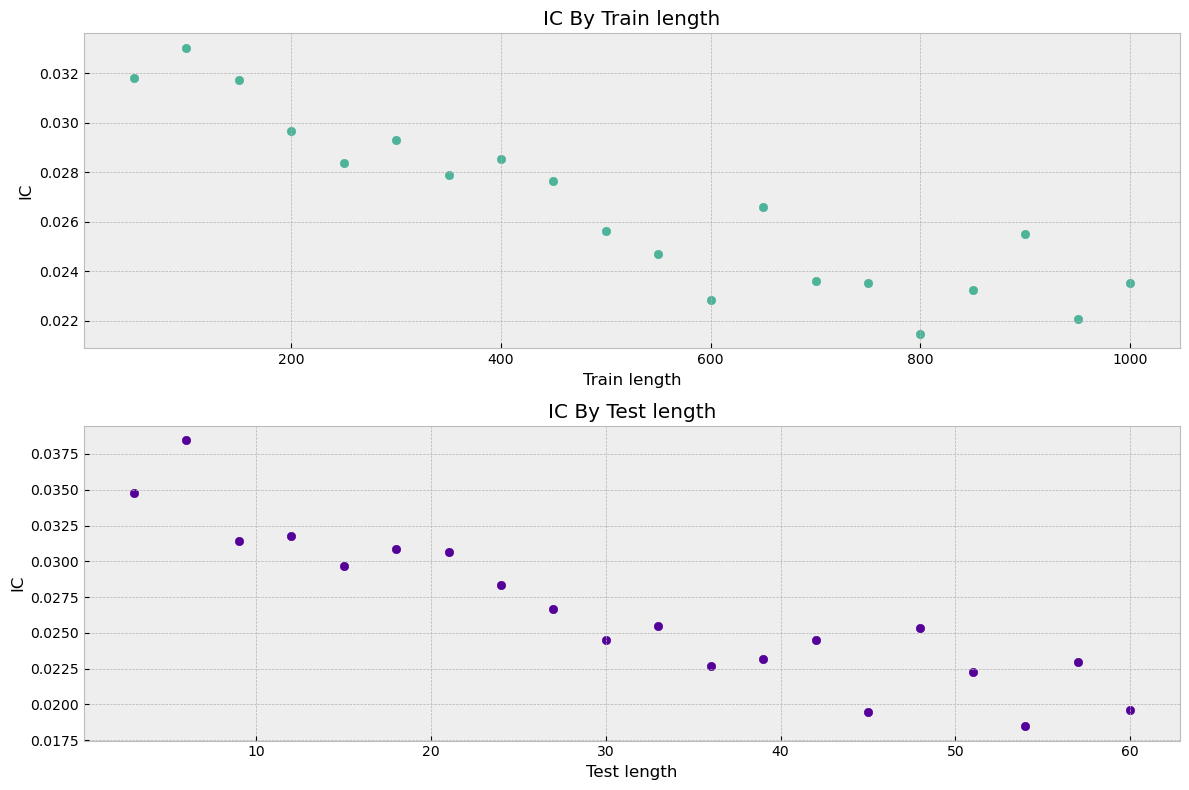

In [13]:
plt.style.use('bmh')
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.title('IC By Train length')
plt.xlabel('Train length')
plt.ylabel('IC')
plt.scatter(x=pd.Series(resultats.train_len.unique()).sort_values(), 
            y=resultats.groupby(by=['train_len']).mean().IC, c='#4db399')
plt.subplot(212)
plt.title('IC By Test length')
plt.xlabel('Test length')
plt.ylabel('IC')
plt.scatter(x=pd.Series(resultats.test_len.unique()).sort_values(), 
            y=resultats.groupby(by=['test_len']).mean().IC, c='#540099')

plt.tight_layout()

Dans cette cellule, nous visualisons la relation entre les longueurs de fenêtre d'entraînement et de test et le score moyen de la validation croisée (IC) en trois dimensions.

Nous utilisons la bibliothèque matplotlib pour créer un graphique 3D. Les axes x et y représentent les longueurs de fenêtre d'entraînement et de test, respectivement, tandis que l'axe z représente le score IC. Chaque point du graphique représente une combinaison de longueurs de fenêtre, et sa hauteur sur l'axe z représente le score IC correspondant. La couleur du point est également déterminée par le score IC, avec une échelle de couleurs allant du bleu (scores faibles) au jaune (scores élevés).

Ce graphique 3D nous permet de visualiser la relation entre les trois variables en même temps. Comme dans les graphiques 2D précédents, nous observons une corrélation négative entre les longueurs de fenêtre et le score IC. Cela signifie que des fenêtres plus courtes tendent à donner de meilleurs scores IC, indiquant que notre modèle est plus efficace pour faire des prédictions à court terme.

<IPython.core.display.Javascript object>


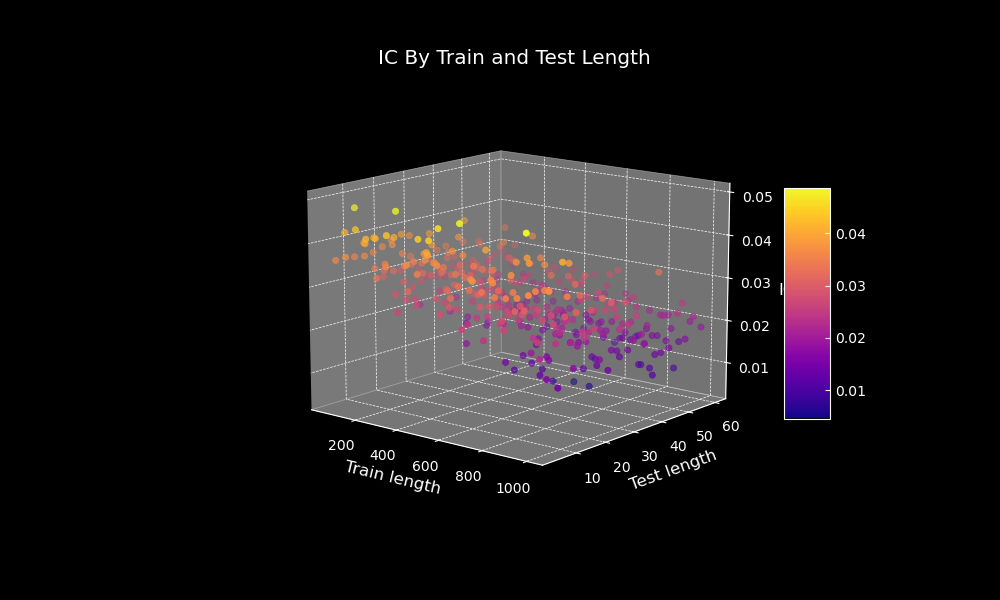

C:\Users\ftiag\AppData\Local\Temp\ipykernel_1612\2409506308.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(scatt, shrink=0.5, aspect=5)


In [14]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('dark_background')
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
scatt = ax.scatter(xs=resultats.train_len, 
                   ys=resultats.test_len, 
                   zs=resultats.IC, 
                   marker='o', 
                   c=resultats.IC, 
                   cmap='plasma')
plt.title('IC By Train and Test Length')
plt.xlabel('Train length')
plt.ylabel('Test length')
ax.set_zlabel('IC')
fig.colorbar(scatt, shrink=0.5, aspect=5)

Dans cette cellule, nous effectuons une régression linéaire pour quantifier la relation entre les longueurs de fenêtre d'entraînement et de test et le score moyen de la validation croisée (IC).

Nous utilisons la méthode des moindres carrés ordinaires (Ordinary Least Squares, OLS) pour ajuster notre modèle de régression. Cette méthode minimise la somme des carrés des résidus, c'est-à-dire la différence entre les valeurs observées et les valeurs prédites par le modèle.

Nous utilisons ensuite la méthode `fit` pour ajuster le modèle à nos données et obtenir les résultats de la régression. Ces résultats comprennent les coefficients de régression pour chaque variable explicative (les longueurs de fenêtre d'entraînement et de test), ainsi que diverses statistiques qui nous permettent d'évaluer la qualité de l'ajustement.

D'après les résultats, nous pouvons voir que les deux variables explicatives sont significatives (leurs p-valeurs sont inférieures à 0.05), ce qui signifie qu'elles ont un effet significatif sur le score IC. Les coefficients de régression sont négatifs, ce qui confirme notre observation précédente d'une corrélation négative entre les longueurs de fenêtre et le score IC.

Le R-carré du modèle est de 0.484, ce qui signifie que le modèle explique environ 48.4% de la variabilité du score IC. C'est une valeur assez élevée, ce qui suggère que le modèle est assez bon pour prédire le score IC à partir des longueurs de fenêtre.

In [18]:
linear_reg = OLS(resultats.IC, add_constant(resultats.drop('IC', axis=1)))
lin_res = linear_reg.fit()
lin_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     IC   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     185.8
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           1.09e-57
Time:                        10:40:28   Log-Likelihood:                 1488.9
No. Observations:                 400   AIC:                            -2972.
Df Residuals:                     397   BIC:                            -2960.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0408      0.001     50.269      0.000       0.039       0.042
train_len  -1.059e-05   1.02e-06    -10.396      0.000   -1.26e-05   -8.59e-06
test_len      -0.0003    1.7e-05    -16.236      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        1.385   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                1.178
Skew:                          -0.053   Prob(JB):                        0.555
Kurtosis:                       3.244   Cond. No.                     1.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""



Dans cette cellule, nous visualisons notre modèle de régression linéaire en trois dimensions.

Nous commençons par générer une grille de valeurs pour les longueurs de fenêtre d'entraînement et de test. Nous utilisons la fonction `linspace` pour générer une séquence de 100 valeurs régulièrement espacées entre le minimum et le maximum de chaque longueur de fenêtre.

Nous utilisons ensuite notre modèle de régression pour prédire le score IC pour chaque combinaison de longueurs de fenêtre. Nous transformons ces prédictions en une matrice 2D qui correspond à notre grille de valeurs.

Nous créons ensuite un graphique 3D avec matplotlib. Nous utilisons la fonction `scatter` pour tracer les scores IC observés pour chaque combinaison de longueurs de fenêtre, et la fonction `plot_surface` pour tracer la surface de régression prédite par notre modèle.

Le graphique montre clairement la relation négative entre les longueurs de fenêtre et le score IC, ainsi que l'ajustement de notre modèle de régression à ces données. La surface de régression donne une représentation visuelle de la relation quantifiée par notre modèle de régression entre les longueurs de fenêtre et le score IC.

In [44]:
test_len_reg = np.linspace(resultats.test_len.min(), resultats.test_len.max(), 100)
train_len_reg = np.linspace(resultats.train_len.min(), resultats.train_len.max(), 100)
x_reg, y_reg = np.meshgrid(train_len_reg, test_len_reg)
onlyX = add_constant(pd.DataFrame({'train_len': x_reg.ravel(), 'test_len': y_reg.ravel()}))
z_reg = np.array(lin_res.predict(onlyX)).reshape(x_reg.shape)

<IPython.core.display.Javascript object>


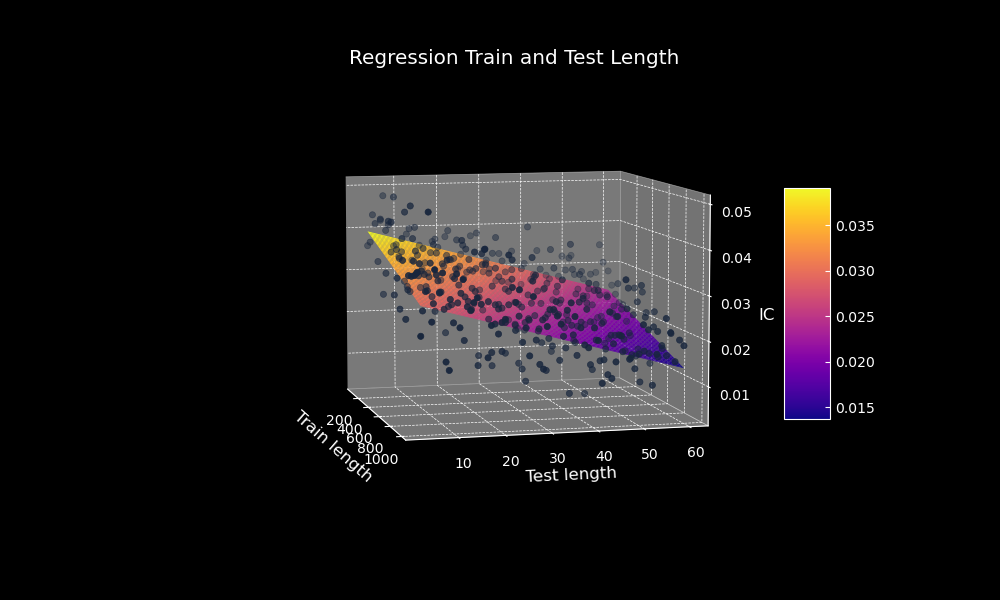

C:\Users\ftiag\AppData\Local\Temp\ipykernel_1612\2120868401.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(surf, shrink=0.5, aspect=5, cmap='plasma')


In [51]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('dark_background')
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
scatt = ax.scatter(xs=resultats.train_len, 
                   ys=resultats.test_len, 
                   zs=resultats.IC, 
                   marker='o', 
                   c='#18263D')
surf = ax.plot_surface(X=x_reg, 
                       Y=y_reg, 
                       Z=z_reg, cmap='plasma')
plt.title('Regression Train and Test Length')
plt.xlabel('Train length')
plt.ylabel('Test length')
ax.set_zlabel('IC')
fig.colorbar(surf, shrink=0.5, aspect=5, cmap='plasma')

# Grid Search CV

In [118]:
rf_predictions = []
for i, (train_idx, test_idx) in enumerate(cv.split(data), 1):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    rf_reg.fit(X=X_train, y=y_train)
    y_pred = rf_reg.predict(X_test)
    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    rf_predictions.append(preds)
    
rf_predictions = pd.concat(rf_predictions, axis=0)

In [119]:
np.array([sp.stats.spearmanr(c.actuals, c.predicted)[0] for c in rf_predictions]).mean()

0.06354083809872936

In [95]:
rf_predictions = rf_predictions.groupby(level='symbol', group_keys=False).apply(lambda x: x.sort_index())

In [122]:
import pickle
with open('predict.pkl', 'wb') as pkl_file:
    pickle.dump(rf_predictions, pkl_file)

In [124]:
with open('predict.pkl', 'rb') as pkl_file:
    k = pickle.load(pkl_file)

In [126]:
k[1]

actuals  predicted
symbol date                                    
AUDJPY 2023-02-21 23:00:00 -0.000119  -0.000171
       2023-02-22 03:00:00 -0.001151  -0.000023
       2023-02-22 07:00:00 -0.001109   0.000023
       2023-02-22 11:00:00  0.000218   0.000091
       2023-02-22 15:00:00 -0.001273   0.000127
       2023-02-22 19:00:00  0.003001   0.000207
AUDUSD 2023-02-21 23:00:00 -0.000585  -0.000171
       2023-02-22 03:00:00 -0.002021  -0.000023
       2023-02-22 07:00:00  0.001377   0.000023
       2023-02-22 11:00:00 -0.001201   0.000091
       2023-02-22 15:00:00 -0.002583   0.000127
       2023-02-22 19:00:00  0.004018   0.000207
EURGBP 2023-02-21 23:00:00  0.001193  -0.000171
       2023-02-22 03:00:00  0.000488  -0.000023
       2023-02-22 07:00:00 -0.001432   0.000023
       2023-02-22 11:00:00  0.000875   0.000091
       2023-02-22 15:00:00  0.000227   0.000127
       2023-02-22 19:00:00  0.000341   0.000207
EURUSD 2023-02-21 23:00:00  0.000009  -0.000171
       2023-02-22 03:00:00 -0.001916  -0.000023
       2023-02-22 07:00:00  0.000836   0.000023
       2023-02-22 11:00:00 -0.001702   0.000091
       2023-02-22 15:00:00 -0.002242   0.000127
       2023-02-22 19:00:00  0.001451   0.000207
GBPJPY 2023-02-21 23:00:00 -0.000723  -0.000171
       2023-02-22 03:00:00 -0.001515  -0.000023
       2023-02-22 07:00:00 -0.000258   0.000023
       2023-02-22 11:00:00 -0.001149   0.000091
       2023-02-22 15:00:00 -0.001205   0.000127
       2023-02-22 19:00:00  0.000234   0.000207
GBPUSD 2023-02-21 23:00:00 -0.001197  -0.000171
       2023-02-22 03:00:00 -0.002382  -0.000023
       2023-02-22 07:00:00  0.002241   0.000023
       2023-02-22 11:00:00 -0.002564   0.000091
       2023-02-22 15:00:00 -0.002488   0.000127
       2023-02-22 19:00:00  0.001129   0.000207
NZDUSD 2023-02-21 23:00:00  0.000594  -0.000171
       2023-02-22 03:00:00 -0.001366  -0.000023
       2023-02-22 07:00:00  0.003243   0.000023
       2023-02-22 11:00:00 -0.000834   0.000091
       2023-02-22 15:00:00 -0.002329   0.000127
       2023-02-22 19:00:00  0.003675   0.000207
USDCAD 2023-02-21 23:00:00  0.000207  -0.000171
       2023-02-22 03:00:00  0.000679  -0.000023
       2023-02-22 07:00:00 -0.001521   0.000023
       2023-02-22 11:00:00 -0.000140   0.000091
       2023-02-22 15:00:00  0.001625   0.000127
       2023-02-22 19:00:00 -0.001869   0.000207
USDCHF 2023-02-21 23:00:00 -0.000475  -0.000171
       2023-02-22 03:00:00  0.001273  -0.000023
       2023-02-22 07:00:00 -0.000323   0.000023
       2023-02-22 11:00:00  0.002348   0.000091
       2023-02-22 15:00:00  0.002021   0.000127
       2023-02-22 19:00:00 -0.001515   0.000207
USDJPY 2023-02-21 23:00:00  0.000468  -0.000171
       2023-02-22 03:00:00  0.000868  -0.000023
       2023-02-22 07:00:00 -0.002509   0.000023
       2023-02-22 11:00:00  0.001411   0.000091
       2023-02-22 15:00:00  0.001291   0.000127
       2023-02-22 19:00:00 -0.000845   0.000207

In [128]:
with pd.HDFStore(r'..\data.h5') as hdf:
    hdf.put('Predictions', rf_predictions)

In [97]:
with pd.HDFStore(r'..\data.h5') as hdf:
    print(hdf['Predictions'])

                             actuals  predicted
symbol date                                    
AUDJPY 2020-08-20 23:00:00 -0.001787   0.000265
       2020-08-21 03:00:00 -0.003609   0.000113
       2020-08-21 07:00:00 -0.000396   0.000107
       2020-08-21 11:00:00 -0.000938   0.000150
       2020-08-21 15:00:00  0.001255   0.000283
...                              ...        ...
USDJPY 2023-02-23 03:00:00  0.000267   0.000203
       2023-02-23 07:00:00  0.002976   0.000169
       2023-02-23 11:00:00 -0.003436   0.000192
       2023-02-23 15:00:00 -0.000898   0.000256
       2023-02-23 19:00:00  0.000705   0.000198

[38940 rows x 2 columns]


In [83]:
params = {
    'n_estimators' : [50, 60, 70],
    'max_depth' : [60, 70, 90],
    'max_features' : [5, 6, 7],
    'min_samples_leaf' : [20, 30, 40]
}

In [88]:
gridsearch_rf = GridSearchCV(estimator=rf_reg,
                             param_grid=params,
                             scoring=ic,
                             n_jobs=-1,
                             cv=cv,
                             return_train_score=True,
                             verbose=1)

In [89]:
gridsearch_rf.fit(X, y)

Fitting 30 folds for each of 81 candidates, totalling 2430 fits


GridSearchCV(cv=<__main__.MultipleTimeSeriesCV object at 0x00000255A50BD640>,
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [60, 70, 90], 'max_features': [5, 6, 7],
                         'min_samples_leaf': [20, 30, 40],
                         'n_estimators': [50, 60, 70]},
             return_train_score=True, scoring=make_scorer(rank_correl),
             verbose=1)

In [90]:
gridsearch_rf.best_estimator_

RandomForestRegressor(max_depth=90, max_features=6, min_samples_leaf=30,
                      n_estimators=50)